In [1]:
import numpy as np
import pandas as pd
# ADD project path instead of module path
import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))
from ets2drive.helpers import read_yaml, read_json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# allow gpu to run
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
config_path = "../config/config.yml"
config = read_yaml(os.path.abspath(config_path))

In [4]:
model_name = '5fps'
model_path = os.path.join(config['model_folder'], model_name)
model = tf.keras.models.load_model(model_path)

In [5]:
os.listdir(config['csv_folder'])

['2021-01-01_02_01_30.csv']

In [6]:
data = pd.read_csv(config['csv_folder'] + '/2021-01-01_02_01_30.csv')

In [7]:
def generateTriggerFeature(data, reference, triggerFeature):
    data[triggerFeature] = [0] * len(data)
    for i in range(1, len(data)):
        if data[reference][i-1] != data[reference][i]:
            data[triggerFeature][i] = 1
            
data['userBrake'] = (data['userBrake'] > 0) * 1
data['userThrottle'] = (data['userThrottle'] > 0) * 1
data['userLeftTurn'] = (data['userSteer'] > 0) * 1
data['userRightTurn'] = (data['userSteer'] < 0) * 1
# generate cruise control trigger
generateTriggerFeature(data, 'cruiseControlOn', 'userCruiseControlTrigger')
# generate left indicator trigger
generateTriggerFeature(data, 'blinkerLeftActive', 'userLeftTurnTrigger')
# generate right indicator trigger
generateTriggerFeature(data, 'blinkerRightActive', 'userRightTurnTrigger')

<ipython-input-7-c9bd436f2b9f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[triggerFeature][i] = 1


In [8]:
img_dir = os.path.join(config['img_folder'], os.listdir(config['img_folder'])[0])

all_image_paths = np.array(data['img'])
for i in range(len(all_image_paths)):
    all_image_paths[i] = os.path.join(img_dir, all_image_paths[i])

all_image_labels = np.array(data[config['label_columns']])

In [9]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

img_count = len(all_image_paths)
print(img_count)
img_count = len(all_image_paths)
# ds = ds.shuffle(img_count)
print(tf.data.experimental.cardinality(ds).numpy())

4504
4504


In [10]:
resized_H = config['resize_H']
resized_W = config['resize_W']
def load_and_preprocess_image(path):
    raw_img = tf.io.read_file(path)
    return preprocess_image(raw_img, resized_H, resized_W)

def preprocess_image(raw_img, h, w):
    img = tf.image.decode_jpeg(raw_img, channels=3)
    # img = tf.image.resize(img, )
    return tf.image.resize(img, [h, w])


# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

ds = ds.map(load_and_preprocess_from_path_label)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = config['BATCH_SIZE']

ds = ds.batch(BATCH_SIZE)

ds = ds.cache().prefetch(buffer_size=AUTOTUNE)


In [12]:
pred = model.predict(ds)

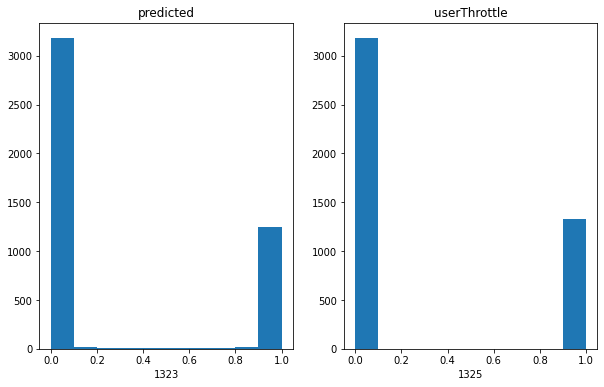

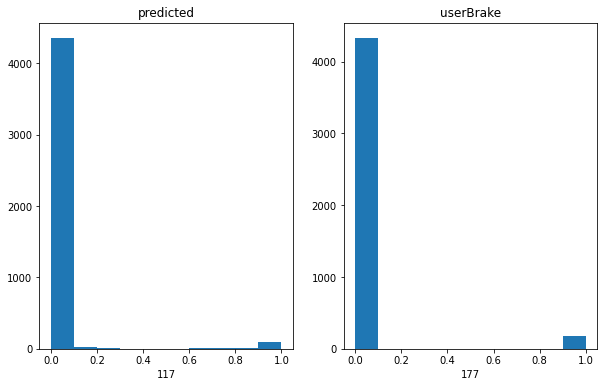

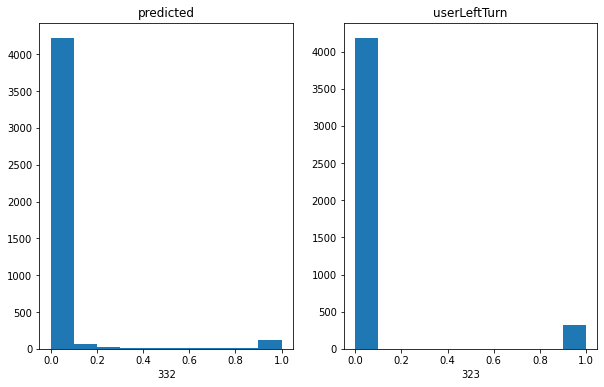

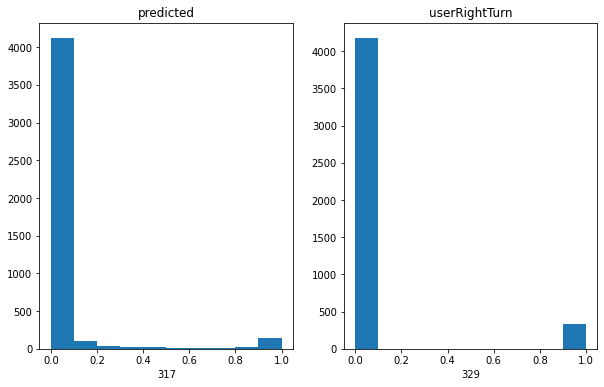

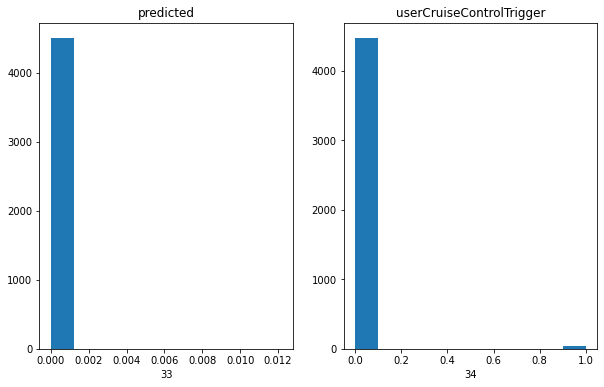

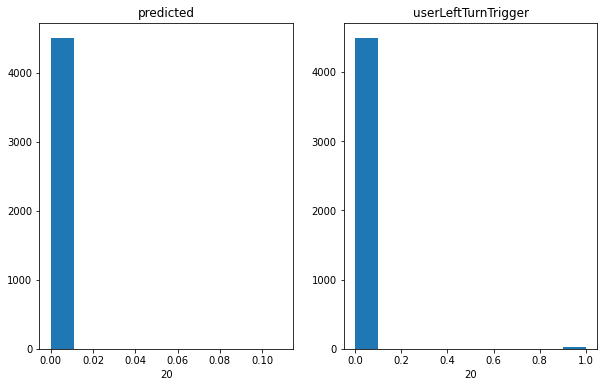

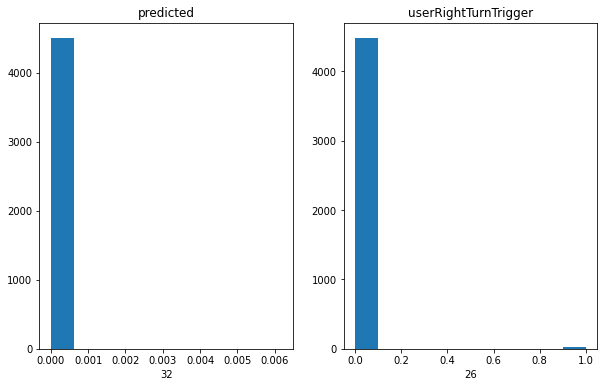

In [56]:
threshold = [0.1, 0.5, 0.07, 0.15, 0.000001, 0.0001, 0.00001]
for i in range(len(config['label_columns'])):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.hist(pred[:, i])
    plt.title('predicted')
    plt.xlabel(sum(pred[:, i]> threshold[i]))
    plt.subplot(1, 2, 2)
    plt.hist(data[config['label_columns'][i]])
    plt.title(config['label_columns'][i])
    plt.xlabel(sum(data[config['label_columns'][i]]))

    

In [20]:
config['label_columns'][0]

'userThrottle'

(array([3179.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1325.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

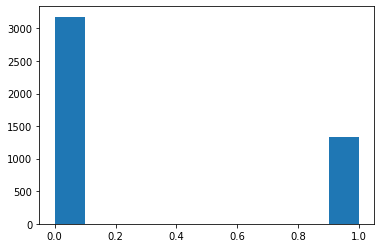